# Coverage objects and residue-level D-uptake

This section of discusses the `Coverage` object. This object describes which part of the
protein is covered by peptides, which peptides cover which part of the protein, and how to
covert data from peptide-level to residue level (and back).

In [1]:
import numpy as np
import pandas as pd
import proplot as pplt
from scipy.optimize import lsq_linear
from pathlib import Path
import yaml

from pyhdx.models import Coverage
from pyhdx.plot import peptide_coverage
from pyhdx.batch_processing import StateParser
from pyhdx.fitting import fit_d_uptake

C:\Users\jhsmi\Miniconda3\envs\py38_pyhdx_01\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Synthetic data

We'll start out by dreaming up some peptides, a sequence, and D-uptake values per residue.
The start-end intervals of peptides are inclusive, exclusive, so the first peptide starts
at residue 2 and up to but does not include residue 7.

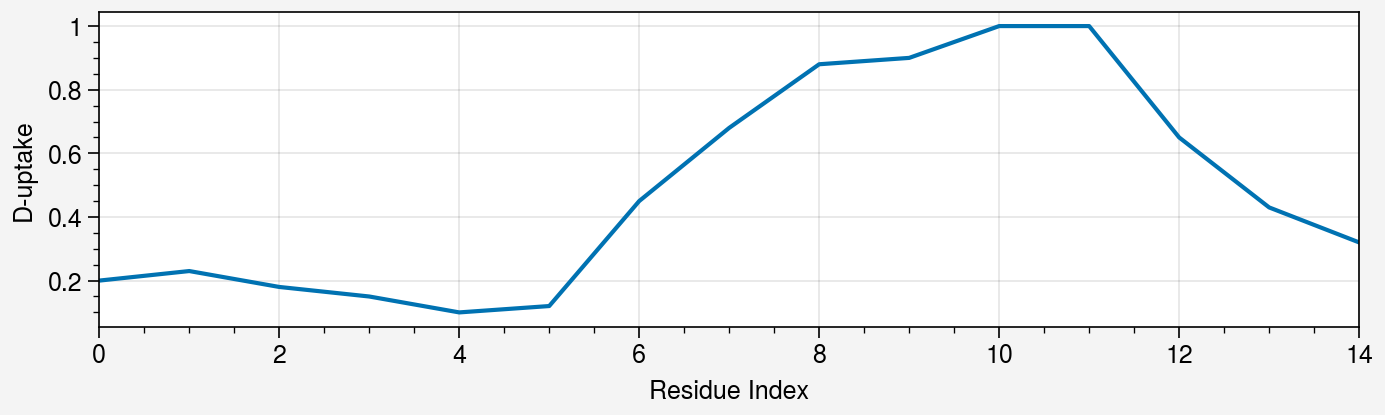

In [2]:
start = [2, 5, 8, 10, 13]
end = [7, 10, 15, 17, 16]
sequence = 'MSEQNNTEMTFQIQRIYTKDISFEAPNAPHVFQKDWQPEVKLDLDTASSQL'
# Data ranges from residue 2 up to but not including 17, therefore these are 15 residues
d_uptake_residue = [0.2, 0.23, 0.18, 0.15, 0.1, 0.12, 0.45, 0.68, 0.88, 0.9, 1.0, 1.0, 0.65, 0.43, 0.32]

fig, ax = pplt.subplots(refaspect=4, axwidth='160mm')
ax.plot(d_uptake_residue)
ax.format(xlabel='Residue Index', ylabel='D-uptake')
pplt.show()

As we can see in the graph above, this data describes a section of 15 residues, where the
first part is relatively rigid (low D-uptake), followed by a flexible section with large uptake
(up to the maximum of 1 per residue), which then drops off again.

Next, we create a pandas ``DataFrame`` such that the data can be passed to a ``Coverage`` object

Aside from the `start` and `stop` entries, a `Coverage` object also needs to know how many
residues exchange per peptide (`ex_residues`). For this example we'll assume no backexchange and
consider all residues as exchanging, therefore this number is equal to the peptide's length.

The fields `exposure` and `state` are also required but are not used. The trailing underscore
fields are used internally and can be ignored for the moment (but `Coverage` expects to find them).

In [3]:
data = {
    'start': np.array(start), 'end': np.array(end),
    '_start': np.array(start), '_end': np.array(end)
}

data['sequence'] = [sequence[s: e] for s, e in zip(data['_start'], data['_end'])]
data['_sequence'] = [sequence[s: e] for s, e in zip(data['_start'], data['_end'])]

data['ex_residues'] = [len(s) for s in data['sequence']]

data['exposure'] = [10.]*len(start)
data['state'] = ['State_A']*len(start)

# make sure we didnt put any prolines in
assert not "P" in ''.join(data['sequence'])

df = pd.DataFrame(data)
df

,start,end,_start,_end,sequence,_sequence,ex_residues,exposure,state
0,2,7,2,7,EQNNT,EQNNT,5,10.0,State_A
1,5,10,5,10,NTEMT,NTEMT,5,10.0,State_A
2,8,15,8,15,MTFQIQR,MTFQIQR,7,10.0,State_A
3,10,17,10,17,FQIQRIY,FQIQRIY,7,10.0,State_A
4,13,16,13,16,QRI,QRI,3,10.0,State_A


This table can be used to make the ``Coverage`` object. This object gives us the 'coupling matrix'
`X`, which is a $N_p$ x $N_r$ matrix, where matrix elements $ij$ are 1 if residue $j$ is in
peptide $i$, otherwise 0.

In [4]:
c = Coverage(df)
c.X

array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]])

This definition of ``X`` means that we can calculate peptide-level D-uptake simply by taking
the dot product between ``X`` and ``d_uptake_residue``

In [5]:
d_uptake_peptide = c.X.dot( np.array(d_uptake_residue) )
d_uptake_peptide

array([0.86, 1.5 , 5.56, 5.18, 2.08])

This means we can also do the inverse operation by taking the pseudoinverse of coupling matrix
``X``.

In [6]:
X_inv = np.linalg.pinv(c.X)
dr_inv = X_inv.dot(d_uptake_peptide)

In principle, we can use this to find residue-level D-uptake values from peptides. However,
these systems of equations are generally underdetermined and real data contains noise and
experimental error, often leading to large errors in estimated residue-level values.

Therefore, a safer approach is to use weighted averaging, which never creates outlying results,
but information (residue resolution) is lost due to the averaging. In this approach,
relative fraction uptake (RFU) values are determined for each peptide, and RFUs for each
residue are then obtained from averaging the RFUs of each peptide in which the residue occurs,
weighted by the inverse length of the peptide, as shorter peptides contain higher resolution information.

In PyHDX, the weight for each peptide is equal to $\frac{1}{n^k}$, where n is the number of
exchanging residues in the peptide and $k$ is a user-configurable value with a default value of 1.

To calculate the weighted average result, we use the ``Z_norm`` property. This matrix is
derived from the matrix ``Z``, which is equivalent to matrix ``X``, but instead of elements
equal to 1, the matrix elements are set to $1/n$. ``Z_norm`` is then the result of setting the
column-wise sum of elements equal to 1, as each column corresponds to a residue such that
the sum of weights adds up to 1.

``Z_norm`` is a property and depends on the value of ``weight_exponent``, so we can change
this value and recalculate weighted averaged residue-level RFU / D-uptake values.

In [7]:
rfu = d_uptake_peptide / c.data['ex_residues']
c.data['rfu'] = rfu
c.weight_exponent = 1
dr_wt_avg = c.Z_norm.T.dot(rfu)
c.weight_exponent = 10
dr_wt_avg_10 = c.Z_norm.T.dot(rfu)

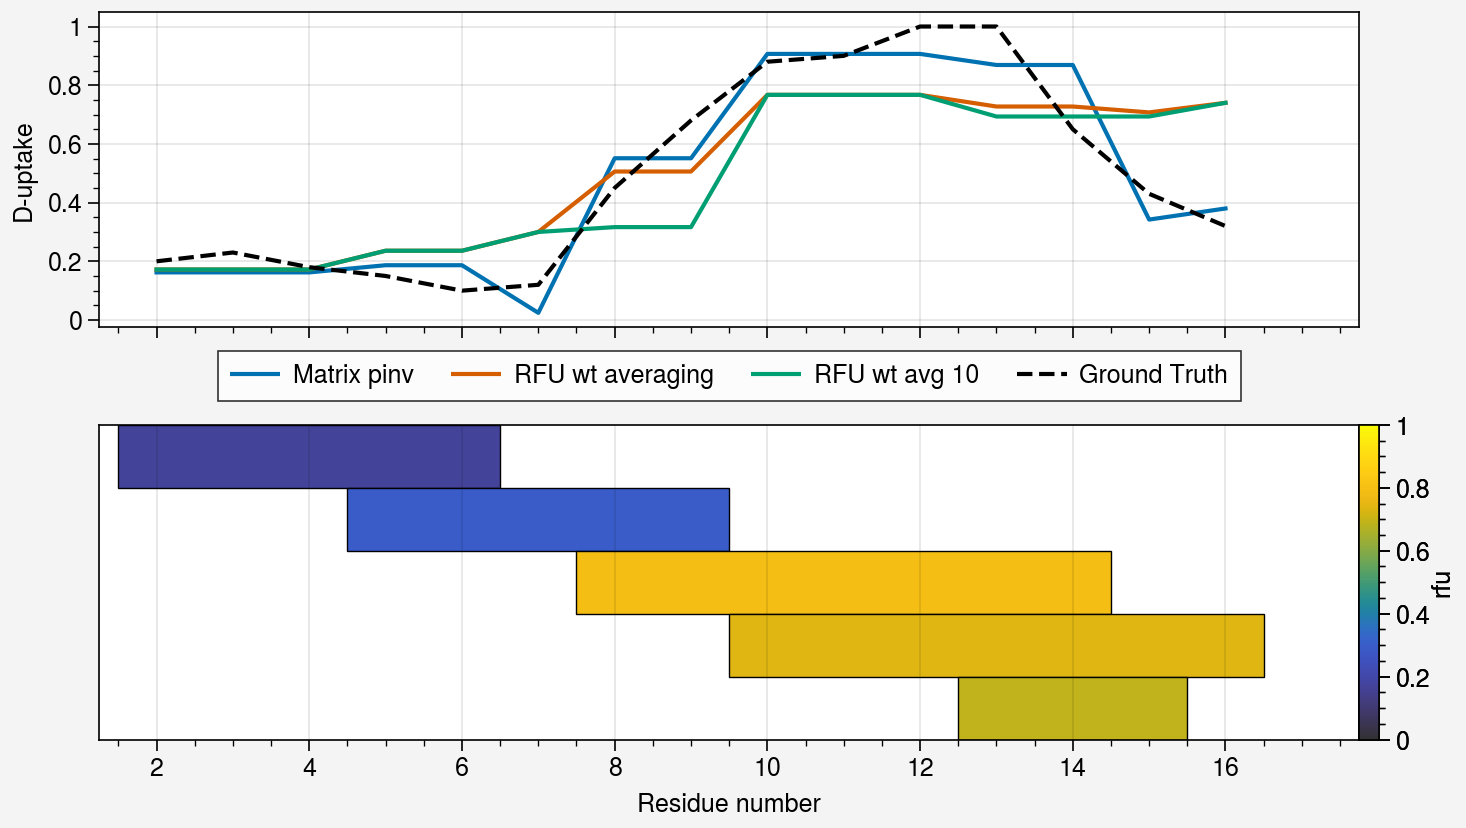

In [8]:
fig, axes = pplt.subplots(nrows=2, refaspect=4, axwidth='160mm', sharey=False)
axes[0].plot(c.r_number, dr_inv, label='Matrix pinv')
axes[0].plot(c.r_number, dr_wt_avg, label='RFU wt averaging')
axes[0].plot(c.r_number, dr_wt_avg_10, label='RFU wt avg 10')
axes[0].plot(c.r_number, d_uptake_residue, label="Ground Truth", color='k', linestyle='--')
peptide_coverage(axes[1], c.data)
axes[0].format(ylabel='D-uptake')
axes[1].format(ylim=(-5, 0))
axes.format(xlabel='Residue number')
axes[0].legend(loc='b', ncols=4)
pplt.show()

## D-uptake values in real data

In this next section we'll load some real HDX data and show different ways of obtaining
residue-level D-uptake.

First, we use ``StateParser`` to quickly load a HDX measurement and apply back-exchange
(by means of Fully Deuterated control) and D percentage corrections. The first N-terminal
residues are considered to be non-exchanging (ie fully exchagne back), which is a parameter
configurable in the config (default equal to 2). This value also modifies the 'coupling matrix'
``X``.

In [9]:
input_dir = Path().resolve().parent.parent / 'tests' / 'test_data' / 'input'
s = yaml.safe_load((input_dir / 'data_states.yaml').read_text())
p = StateParser(state_spec=s, data_src=input_dir)
hdxm = p.load_hdxm("SecB_tetramer")

# select the first timepoint
hdx_t = hdxm[0]

We'll start with the Moore-Penrose inverse, which is a very fast way of obtaining
residue-level D-uptake values.

In [10]:
b = hdx_t.data['uptake_corrected'].values
X_inv = np.linalg.pinv(hdx_t.X)
d_inv = X_inv.dot(b)
# Remove parts which do not exchange (prolines, coverage gaps)
d_inv[~hdx_t['exchanges']] = np.nan

One of the problems with the Moore-Penrose inverse is the possibility of returning values
outside of the allowed bounds of [0, 1]. To alleviate this, we can use Scipy's ``lsq_linear``,
which supports the use of bounds:

In [11]:
res = lsq_linear(hdx_t.X, b, method='bvls', bounds=(0, 1))
d_lsq = res.x
d_lsq[~hdx_t['exchanges']] = np.nan

In [12]:
hdx_t.X.shape

(63, 145)

In [13]:
hdx_t['exchanges'].sum()

115

This gives a slightly better result, but also still suffers from the non-identifyability as the
system is underdetermined (more parameters than datapoints; here we have 115 residues (parameters)
and 63 datapoints (peptides)). This can give results with some 'high frequency' features;
regions where D-uptake along residues varies rapidly, which is likely an unphysical result.

Therefore, PyHDX offers the ``fit_d_uptake`` function, which applies a smoothing penalty
term to the D-uptake result. The degree of smoothing can be controlled by the `r1` parameter.

Here we repeat the fitting 20 times with a random uniform initialized set of parameters, in order
to probe the optimization landscape for local minima.

In [14]:
fit_result_1 = fit_d_uptake(hdx_t, r1=1., repeats=20)

100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


In [15]:
# repeat for a different r1 value
fit_result_02 = fit_d_uptake(hdx_t, r1=0.2, repeats=20)

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Finally, we calculate the D-uptake from weighted averaging. This gives RFU values, so to
convert to D-uptake we need to multiply with the D-percentage of the labelling solution.


In [16]:
d_rfu = hdx_t.rfu_residues*hdxm.metadata["d_percentage"]*0.01

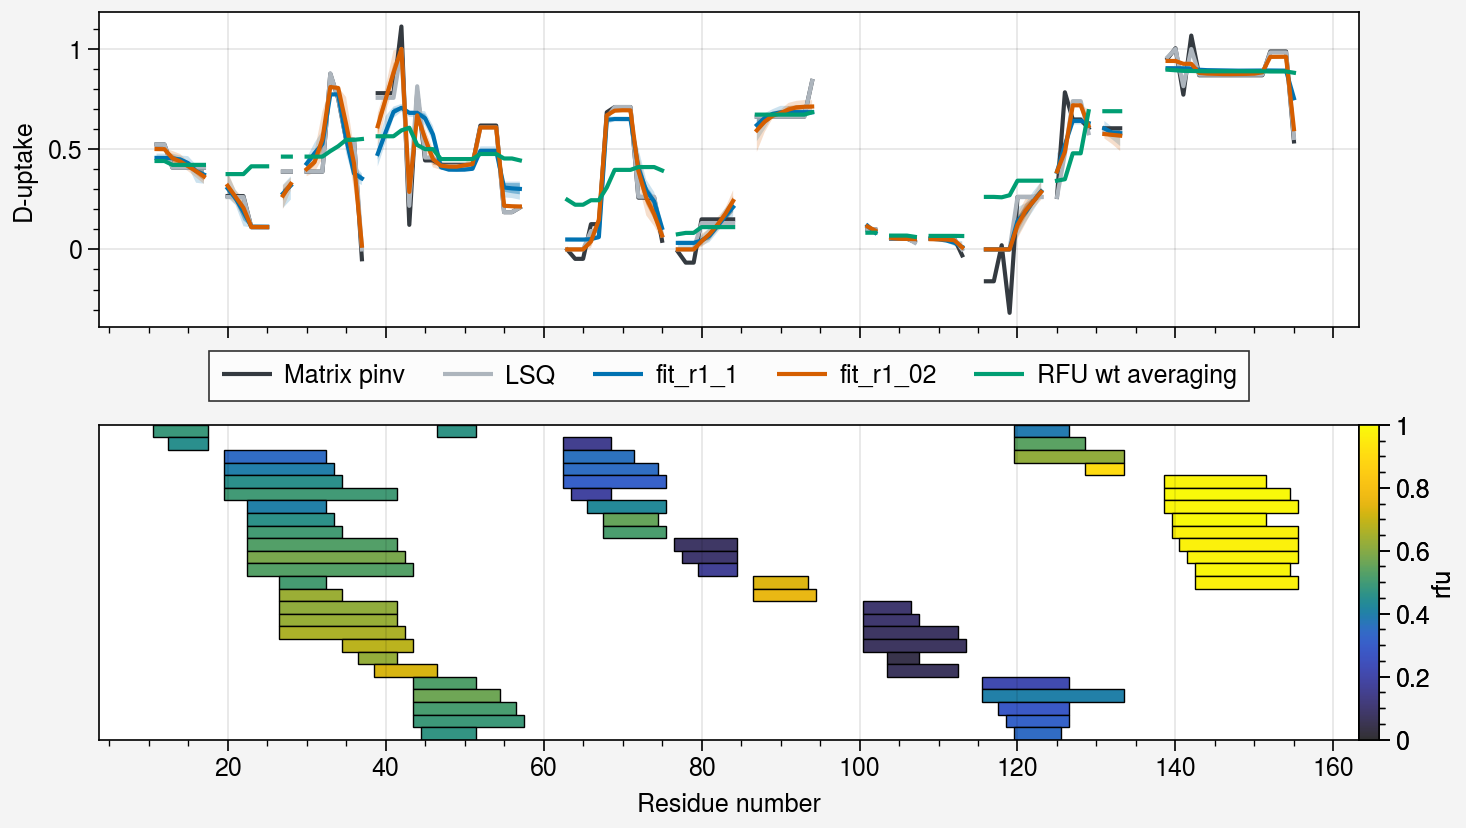

In [17]:
def prepare_kwargs(fit_result):
    """Prepare plot kwargs for fit result"""
    d = {
        'y': fit_result.d_uptake.mean(axis=0),
        'fadedata': np.percentile(fit_result.d_uptake, (5, 95), axis=0),
        'shadedata': np.percentile(fit_result.d_uptake, (25, 75), axis=0)
    }
    return d

fig, axes = pplt.subplots(nrows=2, refaspect=4, axwidth='160mm', sharey=False)
axes[0].plot(hdx_t.r_number, d_inv, label='Matrix pinv', color='gray8')
axes[0].plot(hdx_t.r_number, d_lsq, label='LSQ', color='gray5')

axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_1), label='fit_r1_1')
axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_02), label='fit_r1_02')

axes[0].plot(hdx_t.r_number, d_rfu, label='RFU wt averaging')
axes[0].format(ylabel='D-uptake')
axes.format(xlabel='Residue number')
axes[0].legend(loc='b', ncols=5)
peptide_coverage(axes[1], hdx_t.data)
pplt.show()

As this is now real data, we do not have the luxury of having ground-truth values to compare to.
The pseudoinverse does OK but returns some nonsensical values. Least squares with bounds does a
bit better, but still suffers from high-frequency outliers.
Weighted averaging reliably produces an acceptable result, but high-resolution informatin is lost
due to the averaging.

Least squares fitting with a smoothing penalty offers the best of both worlds. As the fitting
effectively subtracts overlapping peptides, higher resolution results can be expected. This is
especially evident in the region around residue number 70, where a peak in flexibility / D-Uptake
is resolved where weighted averaging smooths over this peak.
Around residue 40, where the pseudoinverse gives artefactual high-frequency features, the
smoothing parameter ensures a more sensible result.
This kind of features can occur when the set of peptides in the region have D-uptake values
which are inconsistent with eachother, so it might make sense to double-check your peptides
in these regions.

We can visualize the goodness of the fit by looking at the value of the residuals per peptide.
This is the difference between the calculated D-uptake and measured D-uptake per peptide and
can be used to identify poorly fitted peptides.
Peptides colored in red (or blue) here have a calculated D-uptake which is higher (lower) than the
measured D-uptake. 

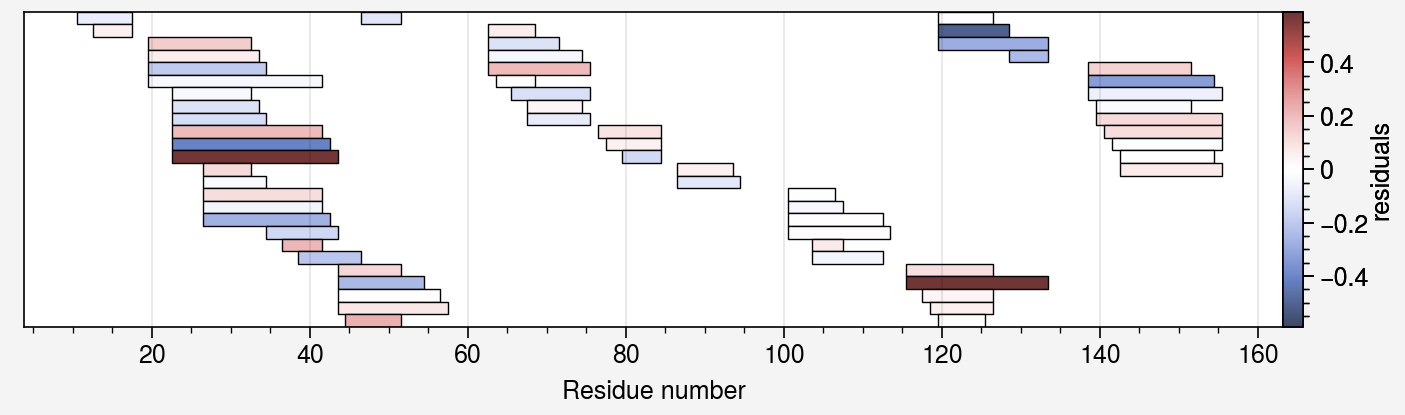

In [23]:
d_calc = hdx_t.X.dot(fit_result_1.output.mean(axis=0))
residuals = d_calc - b
hdx_t.data['residuals'] = residuals

vmax = np.max(np.abs(residuals))
norm = pplt.Norm('linear', vmin=-vmax, vmax=vmax)
cmap = pplt.Colormap('Div')

fig, ax = pplt.subplots(refaspect=4, axwidth='160mm')
peptide_coverage(ax, hdx_t.data, color_field='residuals', cmap=cmap, norm=norm)
ax.format(xlabel='Residue number')
